### Import packages

In [1]:
import os
import sys
import warnings

import datetime
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th

import os
import pickle

import gymnasium as gym
import matplotlib.pyplot as plt

from datetime import datetime
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure  # Import the configure function
from stable_baselines3.common.utils import polyak_update, set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv


### Hyperparameters

In [2]:
# Constants and Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000
BATCH_SIZE = 64 * 4
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 50000

NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256 * 2, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4

EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 95

# EPSILON_DECAY_RATE = 0.000001 # NOT NECCESSARY BECAUSE OPTIMAL EPSILON DECAY RATE IS CALCULATED

N_EPISODES = 1000
CROSS_VAL_INTERVAL = 100

TRAINING_FOLDERS_PATH = '../data/Training/1k-3ac-12f-1dis-F/'
TESTING_FOLDERS_PATH = '../data/Testing/1k-3ac-12f-1dis-F/'

## ESTIMATED VALUES

Calculating...
amount of scenario folders:1000
Estimated Total Training Time: 0.68 hours
Estimated Total Training Time: 41.00 minutes
    Batch Time: 2.46 seconds
    Average Time Per Timestep: 0.000379 seconds
    Average Time Per Scenario: 0.00 seconds

Total Timesteps Estimate: 6492000
Calculated EPSILON_DECAY_RATE: 5.981255397921225e-07

Testing...
amount of scenario folders:1000
Estimated Total Training Time: 0.65 hours
Estimated Total Training Time: 38.92 minutes
    Batch Time: 2.34 seconds
    Average Time Per Timestep: 0.000356 seconds
    Average Time Per Scenario: 0.00 seconds

Total Timesteps Estimate: 6552000
Epsilon reaches its minimum value at 94.13% of total timesteps.


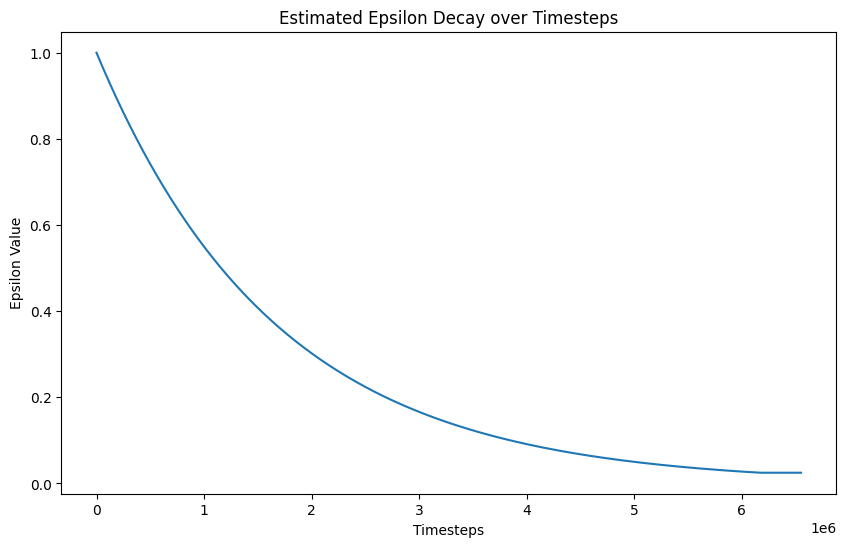

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.environment import AircraftDisruptionEnv

print("Calculating...")
# Calculate total timesteps
estimated_total_timesteps = calculate_total_training_timesteps(TRAINING_FOLDERS_PATH, N_EPISODES)

# Calculate the decay rate
EPSILON_DECAY_RATE = calculate_epsilon_decay_rate(
    estimated_total_timesteps,
    EPSILON_START,
    EPSILON_MIN,
    PERCENTAGE_MIN
)

print("")
print("Testing...")
simulate_and_plot_epsilon_decay(
    training_folders_path=TRAINING_FOLDERS_PATH,
    n_episodes=N_EPISODES,
    epsilon_start=EPSILON_START,
    epsilon_min=EPSILON_MIN,
    epsilon_decay_rate=EPSILON_DECAY_RATE
)


In [4]:
# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
# print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
        f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
last_folder = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
model_name = last_folder
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = f'../trained_models/'
MODEL_SAVE_NAME = f'{model_name}-{formatted_days}-{model_version}.zip'
print(f"Models will be saved to:")
print(f"   {MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME}")
print(f"   {MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME}")

# Create results directory
results_dir = create_results_directory()
print(f"Results directory created at: {results_dir}")

Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training on 1000000 days of data (1000 episodes of 1000 scenarios)
Models will be saved to:
   ../trained_models/myopic_1k-3ac-12f-1dis-F-1M-1.zip
   ../trained_models/proactive_1k-3ac-12f-1dis-F-1M-1.zip
Results directory created at: ../results/20241117-16-55


# Reinforcement Learning

## Training

In [5]:
# Training both agents: myopic and proactive

def train_dqn_agent(env_type):
    # Initialize variables
    rewards = []
    test_rewards = []
    epsilon_values = []
    total_timesteps = 0  # Added to track total timesteps
    action_sequences = {
        os.path.join(TRAINING_FOLDERS_PATH, folder): {
            "best_actions": [],
            "best_reward": float('-inf'),
            "worst_actions": [],
            "worst_reward": float('inf')
        }
        for folder in training_folders
    }
    

    def cross_validate_on_test_data(model, current_episode):
        test_scenario_folders = [
            os.path.join(TESTING_FOLDERS_PATH, folder)
            for folder in os.listdir(TESTING_FOLDERS_PATH)
            if os.path.isdir(os.path.join(TESTING_FOLDERS_PATH, folder))
        ]
        total_test_reward = 0
        for test_scenario_folder in test_scenario_folders:
            # Load data
            data_dict = load_scenario_data(test_scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            from src.environment import AircraftDisruptionEnv
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Evaluate the model on the test scenario without training
            obs, _ = env.reset()

            done_flag = False
            total_reward = 0
            timesteps = 0

            while not done_flag and timesteps < MAX_TIMESTEPS:
                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                # Select the action with the highest masked Q-value
                action = np.argmax(masked_q_values)

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result
                obs_next, reward, terminated, truncated, info = result

                done_flag = terminated or truncated

                # Accumulate the reward
                total_reward += reward

                # Update the current observation
                obs = obs_next

                timesteps += 1

                if done_flag:
                    break

            total_test_reward += total_reward

        # Compute average test reward
        avg_test_reward = total_test_reward / len(test_scenario_folders)
        test_rewards.append((current_episode, avg_test_reward))
        print(f"cros-val done at episode {current_episode}")

    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    total_timesteps = 0  # Reset total_timesteps for each agent

    # Initialize the DQN
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    from src.environment import AircraftDisruptionEnv

    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict,
        env_type=env_type
    )

    model = DQN(
        policy='MultiInputPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device=device
    )

    logger = configure()
    model._logger = logger

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag and timesteps < MAX_TIMESTEPS:
                model.exploration_rate = epsilon

                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                # Select an action
                if np.random.rand() < epsilon:
                    # Exploration: choose a random valid action
                    valid_actions = np.where(action_mask == 1)[0]
                    action = np.random.choice(valid_actions)
                else:
                    # Exploitation: choose the action with the highest masked Q-value
                    action = np.argmax(masked_q_values)

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # print(f"Reward: {reward} for action: {env.map_index_to_action(action)} in scenario: {scenario_folder}")

                # Accumulate the reward
                total_reward += reward

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                epsilon_values.append(epsilon)

                timesteps += 1
                total_timesteps += 1  # Update total_timesteps

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                # Check if the episode is done
                if done_flag:
                    break

            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))

            # Update the worst and best action sequences
            if total_reward < action_sequences[scenario_folder]["worst_reward"]:
                action_sequences[scenario_folder]["worst_actions"] = action_sequence
                action_sequences[scenario_folder]["worst_reward"] = total_reward

            if total_reward > action_sequences[scenario_folder]["best_reward"]:
                action_sequences[scenario_folder]["best_actions"] = action_sequence
                action_sequences[scenario_folder]["best_reward"] = total_reward

        # Perform cross-validation at specified intervals
        if (episode + 1) % CROSS_VAL_INTERVAL == 0:
            cross_validate_on_test_data(model, episode + 1)

        print(f"{env_type}: ({episode + 1}/{N_EPISODES}) rewards: {total_reward}")

    # Save the model after training
    model.save(f"{MODEL_SAVE_PATH}{env_type}_{MODEL_SAVE_NAME}")

    # Return collected data
    return rewards, test_rewards, total_timesteps, epsilon_values  # Added total_timesteps and epsilon_values to the return

# Main code to train both agents and plot results
start_time = datetime.now()

# Train the myopic DQN agents
results_myopic = train_dqn_agent('myopic')
results_proactive = train_dqn_agent('proactive')

# Unpack the results
rewards_myopic, test_rewards_myopic, total_timesteps_myopic, epsilon_values_myopic = results_myopic
rewards_proactive, test_rewards_proactive, total_timesteps_proactive, epsilon_values_proactive = results_proactive


# Save the myopic rewards
myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
print(f"Myopic rewards saved to {myopic_rewards_file}")

# Save the proactive rewards
proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()


Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-11-17-16-55-19-438421
myopic: (1/1000) rewards: -5176.0
myopic: (2/1000) rewards: -14304.0
myopic: (3/1000) rewards: -2000
myopic: (4/1000) rewards: -4836.0
myopic: (5/1000) rewards: -6946.0
myopic: (6/1000) rewards: -3114.0
myopic: (7/1000) rewards: -20544.0
myopic: (8/1000) rewards: -6606.0
myopic: (9/1000) rewards: -6118.0
myopic: (10/1000) rewards: -11514.0
myopic: (11/1000) rewards: -15980.0
myopic: (12/1000) rewards: -6418.0
myopic: (13/1000) rewards: -7574.0
myopic: (14/1000) rewards: -4836.0
myopic: (15/1000) rewards: -14384.0
myopic: (16/1000) rewards: -16116.0
myopic: (17/1000) rewards: -18254.0
myopic: (18/1000) rewards: -7946.0
myopic: (19/1000) rewards: -3000
myopic: (20/1000) rewards: -13226.0
myopic: (21/1000) rewards: -426.0
myopic: (22/1000) rewards: -23108.0
myopic: (23/1000) rewards: -4000
myopic: (24/1000) rewards: -19130.0
myopic: (25/1000) rewards: -16390.0
myopic: (26/1000) rewards: -20422.0
myo

In [16]:
from src.config import *

# Create a dictionary of all hyperparameters and system information
hyperparameters = {
    "Parameter": [
        "LEARNING_RATE", "GAMMA", "BUFFER_SIZE", "BATCH_SIZE",
        "TARGET_UPDATE_INTERVAL", "EPSILON_START", "EPSILON_MIN",
        "EPSILON_DECAY_RATE", "MAX_TIMESTEPS", "LEARNING_STARTS",
        "TRAIN_FREQ", "N_EPISODES", "NEURAL_NET_STRUCTURE",
        "TRAINING_FOLDERS_PATH", "TESTING_FOLDERS_PATH", "MODEL_SAVE_PATH",
        "MODEL_SAVE_NAME", "runtime_in_seconds", "runtime_in_hh:mm:ss",
        "total_timesteps_myopic", "total_timesteps_proactive", "device",
        "device_info", "MAX_AIRCRAFT", "MAX_FLIGHTS_PER_AIRCRAFT",
        "TIMESTEP_HOURS", "DUMMY_VALUE", "RESOLVED_CONFLICT_REWARD",
        "DELAY_MINUTE_PENALTY", "MAX_DELAY_PENALTY", "NO_ACTION_PENALTY",
        "CANCELLED_FLIGHT_PENALTY", "MIN_TURN_TIME", "CROSS_VAL_INTERVAL",
        "PERCENTAGE_MIN"
    ],
    "Value": [
        LEARNING_RATE, GAMMA, BUFFER_SIZE, BATCH_SIZE,
        TARGET_UPDATE_INTERVAL, EPSILON_START, EPSILON_MIN,
        EPSILON_DECAY_RATE, MAX_TIMESTEPS, LEARNING_STARTS,
        TRAIN_FREQ, N_EPISODES, str(NEURAL_NET_STRUCTURE),
        TRAINING_FOLDERS_PATH, TESTING_FOLDERS_PATH, MODEL_SAVE_PATH,
        MODEL_SAVE_NAME, runtime_in_seconds, str(runtime),
        total_timesteps_myopic, total_timesteps_proactive, device,
        str(device_info), MAX_AIRCRAFT, MAX_FLIGHTS_PER_AIRCRAFT,
        TIMESTEP_HOURS, DUMMY_VALUE, RESOLVED_CONFLICT_REWARD,
        DELAY_MINUTE_PENALTY, MAX_DELAY_PENALTY, NO_ACTION_PENALTY,
        CANCELLED_FLIGHT_PENALTY, MIN_TURN_TIME, CROSS_VAL_INTERVAL,
        PERCENTAGE_MIN
    ]
}

# Convert the dictionary to a DataFrame
hyperparameters_df = pd.DataFrame(hyperparameters)

# Define the path for the CSV file
csv_file_path = os.path.join(results_dir, "hyperparameters.csv")

# Save the DataFrame to a CSV file
hyperparameters_df.to_csv(csv_file_path, index=False)
print(f"All hyperparameters saved to {csv_file_path}")


All hyperparameters saved to ../results/20241117-16-55/hyperparameters.csv


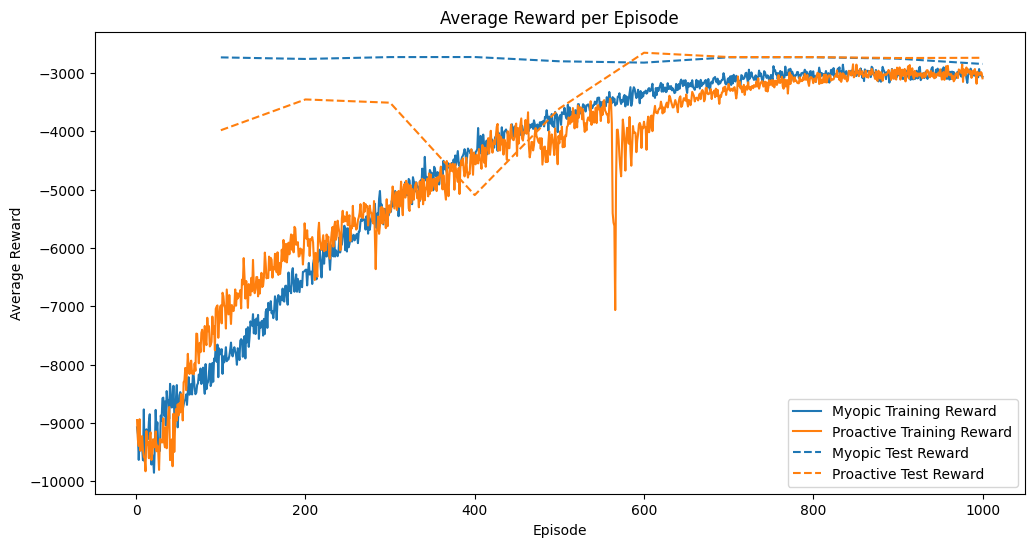

In [6]:
# Process training rewards per episode for myopic
episode_rewards_myopic = {}
for episode, scenario_folder, total_reward in rewards_myopic:
    if episode not in episode_rewards_myopic:
        episode_rewards_myopic[episode] = []
    episode_rewards_myopic[episode].append(total_reward)

avg_rewards_per_episode_myopic = []
episodes_myopic = []
for episode in sorted(episode_rewards_myopic.keys()):
    avg_reward = np.mean(episode_rewards_myopic[episode])
    avg_rewards_per_episode_myopic.append(avg_reward)
    episodes_myopic.append(episode + 1)  # episode numbers start from 0, so add 1

# Process training rewards per episode for proactive
episode_rewards_proactive = {}
for episode, scenario_folder, total_reward in rewards_proactive:
    if episode not in episode_rewards_proactive:
        episode_rewards_proactive[episode] = []
    episode_rewards_proactive[episode].append(total_reward)

avg_rewards_per_episode_proactive = []
episodes_proactive = []
for episode in sorted(episode_rewards_proactive.keys()):
    avg_reward = np.mean(episode_rewards_proactive[episode])
    avg_rewards_per_episode_proactive.append(avg_reward)
    episodes_proactive.append(episode + 1)  # episode numbers start from 0, so add 1

# Extract test rewards for myopic
test_episodes_myopic = [ep for ep, _ in test_rewards_myopic]
test_avg_rewards_myopic = [reward for _, reward in test_rewards_myopic]

# Extract test rewards for proactive
test_episodes_proactive = [ep for ep, _ in test_rewards_proactive]
test_avg_rewards_proactive = [reward for _, reward in test_rewards_proactive]

# Plot the average rewards over the episodes
plt.figure(figsize=(12, 6))

# Plot training rewards
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')


plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_episode.png'))
plt.show()


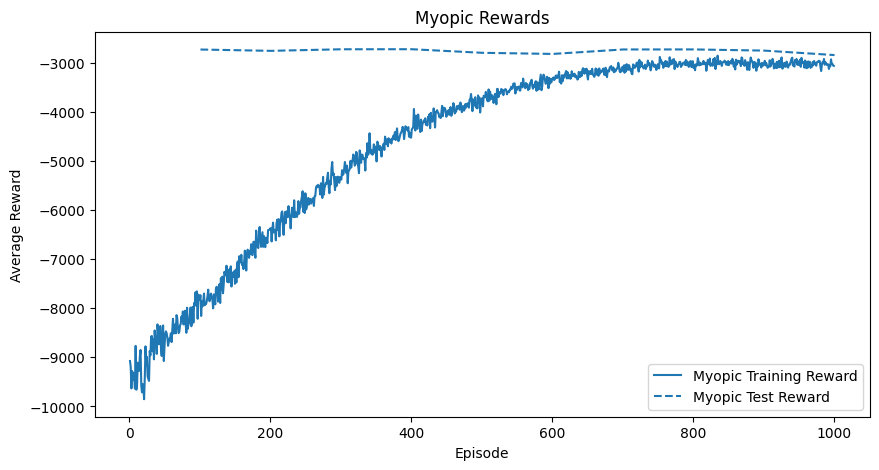

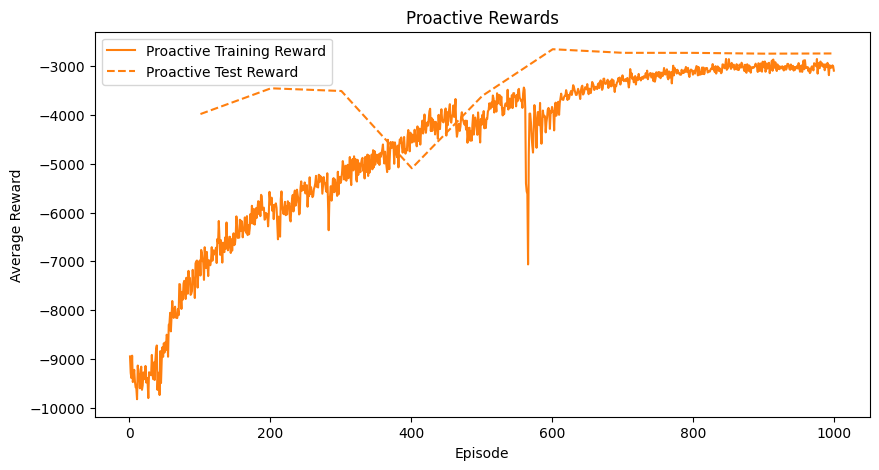

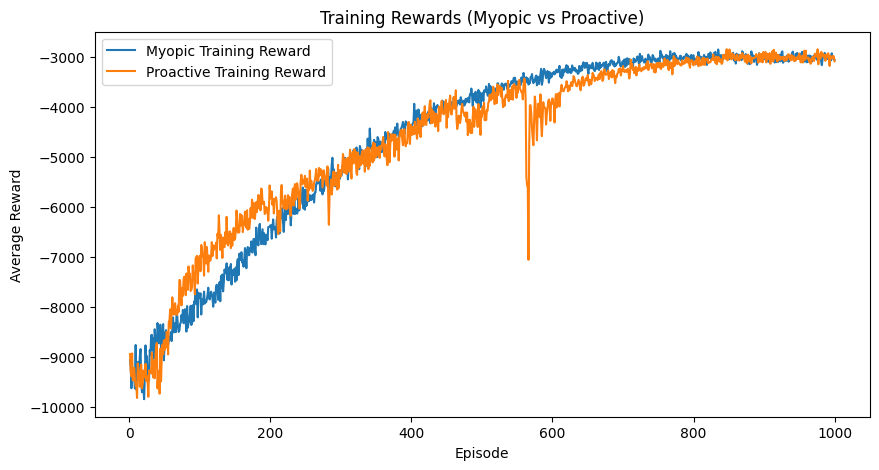

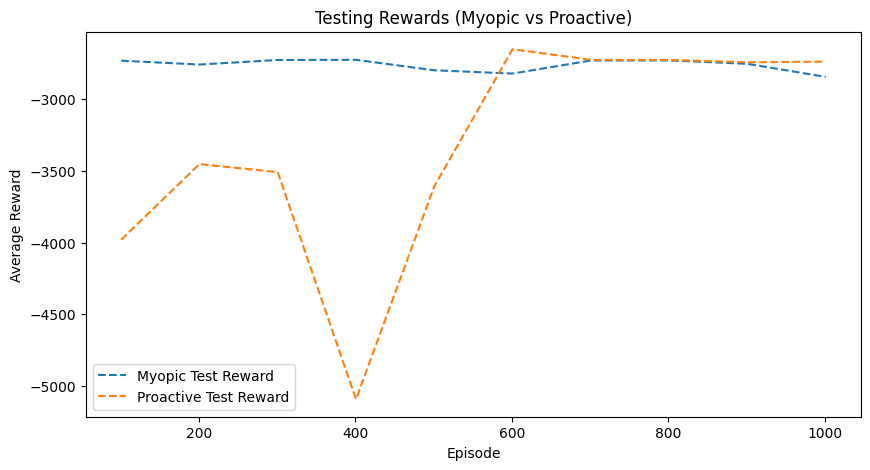

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Process training rewards per episode for myopic
episode_rewards_myopic = {}
for episode, scenario_folder, total_reward in rewards_myopic:
    if episode not in episode_rewards_myopic:
        episode_rewards_myopic[episode] = []
    episode_rewards_myopic[episode].append(total_reward)

avg_rewards_per_episode_myopic = []
episodes_myopic = []
for episode in sorted(episode_rewards_myopic.keys()):
    avg_reward = np.mean(episode_rewards_myopic[episode])
    avg_rewards_per_episode_myopic.append(avg_reward)
    episodes_myopic.append(episode + 1)  # episode numbers start from 0, so add 1

# Process training rewards per episode for proactive
episode_rewards_proactive = {}
for episode, scenario_folder, total_reward in rewards_proactive:
    if episode not in episode_rewards_proactive:
        episode_rewards_proactive[episode] = []
    episode_rewards_proactive[episode].append(total_reward)

avg_rewards_per_episode_proactive = []
episodes_proactive = []
for episode in sorted(episode_rewards_proactive.keys()):
    avg_reward = np.mean(episode_rewards_proactive[episode])
    avg_rewards_per_episode_proactive.append(avg_reward)
    episodes_proactive.append(episode + 1)  # episode numbers start from 0, so add 1

# Extract test rewards for myopic
test_episodes_myopic = [ep + 1 for ep, _ in test_rewards_myopic]  # episode numbers start from 0, so add 1
test_avg_rewards_myopic = [reward for _, reward in test_rewards_myopic]

# Extract test rewards for proactive
test_episodes_proactive = [ep + 1 for ep, _ in test_rewards_proactive]  # episode numbers start from 0, so add 1
test_avg_rewards_proactive = [reward for _, reward in test_rewards_proactive]

# Plot 1: Myopic (Training and Testing)
plt.figure(figsize=(10, 5))
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Myopic Rewards')
plt.show()

# Plot 2: Proactive (Training and Testing)
plt.figure(figsize=(10, 5))
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')
plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Proactive Rewards')
plt.show()

# Plot 3: Training Rewards (Myopic and Proactive)
plt.figure(figsize=(10, 5))
plt.plot(episodes_myopic, avg_rewards_per_episode_myopic, label='Myopic Training Reward', color='C0')
plt.plot(episodes_proactive, avg_rewards_per_episode_proactive, label='Proactive Training Reward', color='C1')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Training Rewards (Myopic vs Proactive)')
plt.show()

# Plot 4: Testing Rewards (Myopic and Proactive)
plt.figure(figsize=(10, 5))
plt.plot(test_episodes_myopic, test_avg_rewards_myopic, label='Myopic Test Reward', color='C0', linestyle='--')
plt.plot(test_episodes_proactive, test_avg_rewards_proactive, label='Proactive Test Reward', color='C1', linestyle='--')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Testing Rewards (Myopic vs Proactive)')
plt.show()



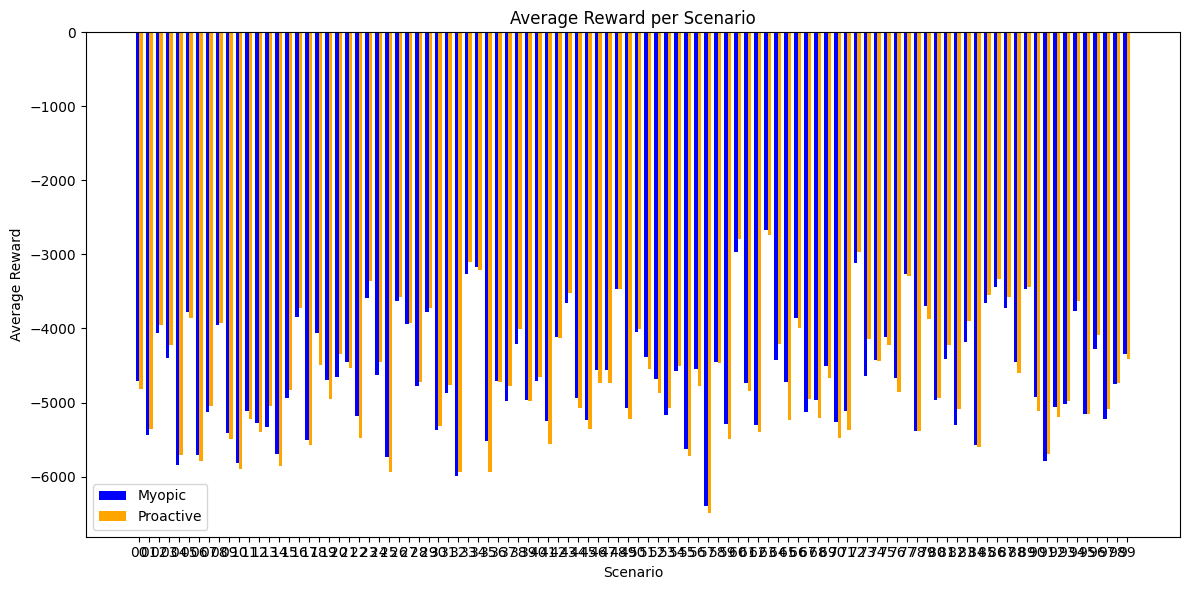

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize dictionaries to store rewards for each scenario
scenario_rewards_myopic = defaultdict(list)
scenario_rewards_proactive = defaultdict(list)

# Iterate through the rewards list and group by scenario (last two characters) for myopic model
for _, scenario, reward in rewards_myopic:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards_myopic[scenario_id].append(reward)

# Iterate through the rewards list and group by scenario (last two characters) for proactive model
for _, scenario, reward in rewards_proactive:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards_proactive[scenario_id].append(reward)

# Calculate the average reward for each scenario for both models
avg_rewards_per_scenario_myopic = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards_myopic.items()}
avg_rewards_per_scenario_proactive = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards_proactive.items()}

# Get all unique scenarios
all_scenarios = set(avg_rewards_per_scenario_myopic.keys()).union(avg_rewards_per_scenario_proactive.keys())
sorted_scenarios = sorted(all_scenarios)

# Extract the sorted average rewards for both models
sorted_avg_rewards_myopic = [avg_rewards_per_scenario_myopic.get(scenario, 0) for scenario in sorted_scenarios]
sorted_avg_rewards_proactive = [avg_rewards_per_scenario_proactive.get(scenario, 0) for scenario in sorted_scenarios]

# Plot a grouped bar chart with scenarios on the x-axis and average rewards on the y-axis
x = np.arange(len(sorted_scenarios))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, sorted_avg_rewards_myopic, width, label='Myopic', color='blue')
plt.bar(x + width/2, sorted_avg_rewards_proactive, width, label='Proactive', color='orange')

plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')
plt.xticks(x, sorted_scenarios)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_scenario.png'))
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the new folder within results_dir
scenario_results_dir = os.path.join(results_dir, 'plots', 'reward-plots-per-scenario')
os.makedirs(scenario_results_dir, exist_ok=True)

# Get all unique scenario IDs from both models
all_scenario_ids = set(scenario_rewards_myopic.keys()).union(scenario_rewards_proactive.keys())

# Iterate over all scenarios
for scenario_id in all_scenario_ids:
    # Get rewards lists for both models
    rewards_list_myopic = scenario_rewards_myopic.get(scenario_id, [])
    rewards_list_proactive = scenario_rewards_proactive.get(scenario_id, [])
    
    # Initialize the plot
    plt.figure(figsize=(12, 6))
    
    # Plot for Myopic model
    if rewards_list_myopic:
        window_myopic = min(100, len(rewards_list_myopic))  # Adjust window size as needed
        smoothed_rewards_myopic = np.convolve(rewards_list_myopic, np.ones(window_myopic) / window_myopic, mode='same')
        plt.plot(rewards_list_myopic, label='Myopic Reward', color='blue', alpha=0.3)
        plt.plot(smoothed_rewards_myopic, label='Myopic Smoothed Reward', color='blue')
    
    # Plot for Proactive model
    if rewards_list_proactive:
        window_proactive = min(100, len(rewards_list_proactive))  # Adjust window size as needed
        smoothed_rewards_proactive = np.convolve(rewards_list_proactive, np.ones(window_proactive) / window_proactive, mode='same')
        plt.plot(rewards_list_proactive, label='Proactive Reward', color='orange', alpha=0.3)
        plt.plot(smoothed_rewards_proactive, label='Proactive Smoothed Reward', color='orange')
    
    # Set labels and title
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Reward per Episode for Scenario {scenario_id}')
    plt.legend()
    
    # Save the plot
    plot_filename = f'average_reward_for_scenario_{scenario_id}.png'
    plt.savefig(os.path.join(scenario_results_dir, plot_filename))
    plt.close()


total_timesteps_proactive 7478873
total_timesteps_myopic 8226158


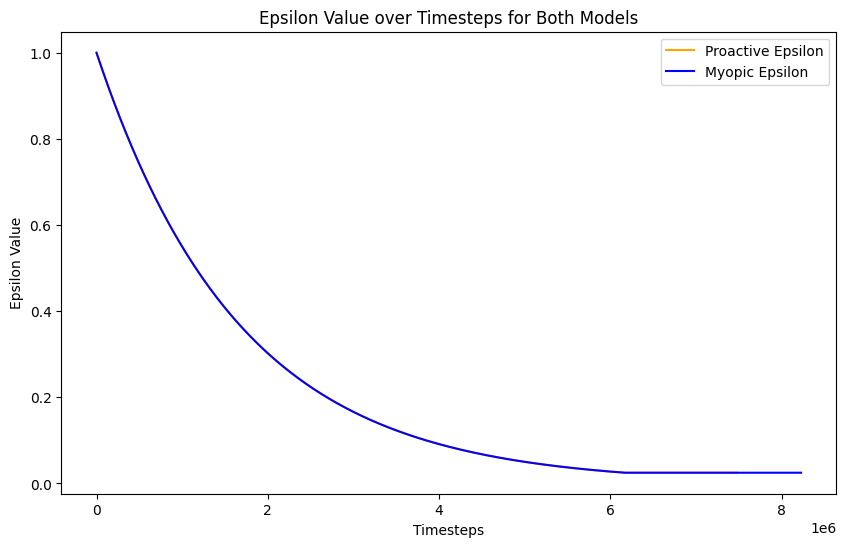

In [10]:
print("total_timesteps_proactive", total_timesteps_proactive)
print("total_timesteps_myopic", total_timesteps_myopic)

# Plot the epsilon values over the episodes for both models
plt.figure(figsize=(10, 6))

# Plot for Proactive model
plt.plot(range(len(epsilon_values_proactive)), epsilon_values_proactive, label='Proactive Epsilon', color='orange')
plt.plot(range(len(epsilon_values_myopic)), epsilon_values_myopic, label='Myopic Epsilon', color='blue')

plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps for Both Models')
plt.legend()
plt.savefig(os.path.join(results_dir, 'plots', 'epsilon_value_over_timesteps_both_models.png'))
plt.show()